In [1]:
import pandas as pd
import json
import umap
import numpy as np
import chromadb
import pickle
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction


KeyboardInterrupt: 

In [1]:

df = pd.read_csv('./data/sc-data-abhidhamma.csv', index_col=0)
print(df.head(2))

                      book                  title  \
0  Compendium of Phenomena  1.1. Matrix of Triads   
1  Compendium of Phenomena  1.1. Matrix of Triads   

                      subtitle  \
0   1.1.1. The “skilful” triad   
1  1.1.2. The “feelings” triad   

                                             content  \
0   Phenomena that are skilful.\nPhenomena that a...   
1  Phenomena associated with pleasant feelings.\n...   

                                       citation_text  citation_url  
0  Abhidhammamātikā: The Matrix from the Abstract...           NaN  
1  Abhidhammamātikā: The Matrix from the Abstract...           NaN  


In [2]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)

token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

chunked_rows = []
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Chunking the dataframe"):
    token_split_texts = []
    split_texts = character_splitter.split_text(str(row["content"]))
    for text in split_texts:
        token_split_texts += token_splitter.split_text(text)
        
    chunked_rows.extend(
        [
            {**row.copy(), "content": chunk}
            for chunk in token_split_texts
        ]
    )
with open('chunked_tmp.json', 'w') as f:
    json.dump(chunked_rows, f)

print(f"\nTotal chunks {len(chunked_rows)}")

c:\Users\User\.virtualenvs\tipitaka-rag-OgL2bDfl\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\User\.virtualenvs\tipitaka-rag-OgL2bDfl\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Chunking the dataframe:   0%|          | 0/1527 [00:00<?, ?it/s]


Total chunks 5845


In [3]:
with open('chunked_tmp.json', 'r') as f:
    chunked_rows = json.load(f)

In [5]:
embedding_function = SentenceTransformerEmbeddingFunction()
collection_name = "abhidhamma-search"

chroma_client = chromadb.PersistentClient(path="./db")
chroma_collection = chroma_client.create_collection(
    collection_name, get_or_create=True, embedding_function=embedding_function
)

In [10]:
reset = False
if reset:
    chroma_client.delete_collection(collection_name)
    chroma_collection = chroma_client.create_collection(
        collection_name, get_or_create=True, embedding_function=embedding_function
    )

In [38]:
ids = [str(i) for i in range(len(chunked_rows))]

batch_size = 1000
index = 0
size = len(chunked_rows)

# ids, docs, metadatas
batches = []

with tqdm(total=size, desc="Creating batches from data") as pbar:
    while True:
        start = index
        end = min(index + batch_size, len(chunked_rows))

        batch = chunked_rows[start:end]
        documents = []
        metadatas = []

        for i in batch:
            i = i.copy()
            content = i.pop("content")
            documents.append(content)
            metadatas.append(i)
            pbar.update(1)
        batches.append((ids[start:end], documents, metadatas))
        index += batch_size
        if index >= size:
            break

for chk_ids, docs, metas in tqdm(batches, desc="Adding batches"):
    chroma_collection.add(
        ids=chk_ids,
        documents=docs,
        metadatas=metas
    )

Creating batches from data:   0%|          | 0/5845 [00:00<?, ?it/s]

Adding batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [6]:
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings   
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)


<module 'umap' from 'c:\\Users\\User\\.virtualenvs\\tipitaka-rag-OgL2bDfl\\Lib\\site-packages\\umap\\__init__.py'>


c:\Users\User\.virtualenvs\tipitaka-rag-OgL2bDfl\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


  0%|          | 0/5845 [00:00<?, ?it/s]

In [11]:
with open('projected_dataset_embeddings.pkl', 'wb') as f:
    pickle.dump(projected_dataset_embeddings, f)

(-14.296531867980956,
 26.081802558898925,
 -17.402178382873537,
 20.97694263458252)

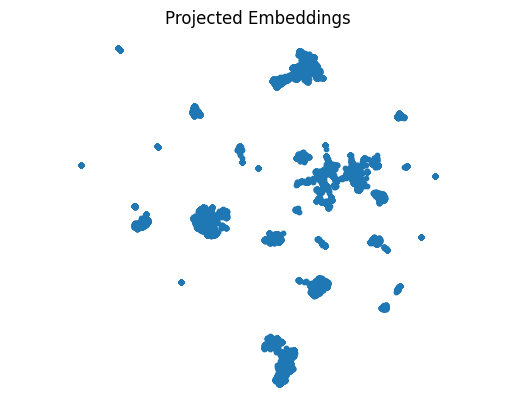

In [8]:
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')